In [1]:
from QES.Algebra.Model.Interacting.Spin.heisenberg_kitaev   import HeisenbergKitaev, HoneycombLattice
from QES.Algebra.hilbert                                    import HilbertSpace
from QES.Algebra.Operator.impl.operators_spin               import sig_x, sig_z, spin_plaquette, spin_plaquettes
from QES.Algebra.Operator.impl.operators_spin               import spin_plaquette

import matplotlib.pyplot                                    as plt
import numpy                                                as np

In [2]:
lat             = HoneycombLattice(lx=2, ly=2)
lat

HON,pbc,d=2,Ns=8,Lx=2,Ly=2,Lz=1

In [3]:
sigma_x_0       = sig_x(lattice=lat, sites=0)
sigma_z_1       = sig_z(lattice=lat, sites=1)
sigma_z_0       = sig_z(lattice=lat, sites=0)

In [4]:
plaquettes      = lat.calculate_plaquettes()
plaquette0_op   = spin_plaquette(plaquettes[0], lattice=lat, return_op=True)
plaquette1_op   = spin_plaquette(plaquettes[1], lattice=lat, return_op=True)
plaquette2_op   = spin_plaquette(plaquettes[2], lattice=lat, return_op=True)
plaquettes_op   = spin_plaquettes([plaquettes[0], plaquettes[1]], lattice=lat, return_op=True)
plaquettes_op2  = spin_plaquettes([plaquettes[0], plaquettes[2]], lattice=lat, return_op=True)

(<Figure size 525x393.75 with 1 Axes>, <Axes: >)

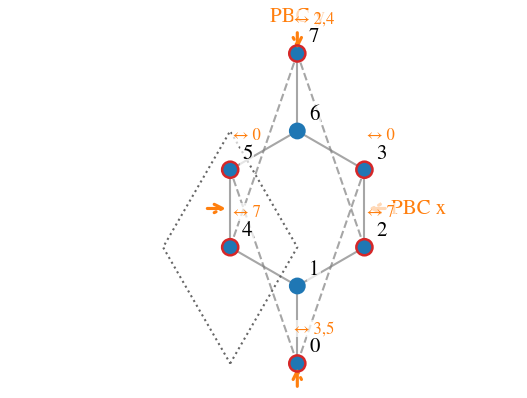

In [5]:
lat.plot_structure(show_indices=True)

### a) NO SYMMETRIES

In [6]:
hilbert_no_sym  =   HilbertSpace(lattice=lat)
model_no_sym    =   HeisenbergKitaev(
                        lattice         =   lat, 
                        hilbert_space   =   hilbert_no_sym, 
                        dtype           =   complex,
                        K               =   (1.0, 1.0, 1.0),
                        hz              =   0.5
                )
model_no_sym

Kitaev(Ns=8,Kx=1.000,Ky=1.000,Kz=1.000,dlt=1.000,hz=0.500)

23_12_2025_08-56_21 [INFO] 		->[Kitaev-Heisenberg-Gamma Model] Calculating the Hamiltonian matrix using NumPy...


array([-7.15595497, -6.83620973, -6.60426915, -6.56549737, -6.51242173,
       -6.51242173, -6.29252874, -6.29150262, -6.29150262, -6.12469583,
       -6.12469583, -6.12469583, -6.12469583, -6.11932588, -6.11932588,
       -6.00650183, -6.00650183, -6.        , -5.87006123, -5.87006123,
       -5.87006123, -5.87006123, -5.82704064, -5.82704064, -5.80642385,
       -5.62721301, -5.55142571, -5.55142571, -5.55011799, -5.46410162,
       -4.52802985, -4.52802985, -4.29773893, -4.29773893, -4.29241237,
       -4.29241237, -4.24086627, -4.        , -4.        , -3.93872951,
       -3.93872951, -3.93872951, -3.93872951, -3.88544119, -3.79690025,
       -3.66725622, -3.66725622, -3.52695625, -3.52695625, -3.46410162])

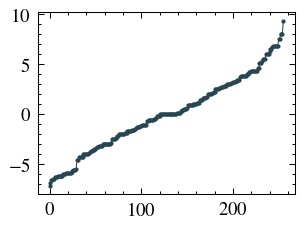

In [7]:
if model_no_sym.eig_val is None: 
    model_no_sym.diagonalize(build=True)

plt.figure(figsize=(2,1.5))
plt.plot(model_no_sym.eig_val, marker='o', ms=1, lw=0.5)
model_no_sym.eig_val[:50]

#### i) Check matrix-vector product for operators that commute with the Hamiltionian $[H, O] = 0$

In [8]:
s_new = model_no_sym.matvec(model_no_sym.eig_vec[:, 0])
s_ovr = np.vdot(model_no_sym.eig_vec[:, 0], s_new)
s_ovr

np.complex128(-7.155954970761078+0j)

#### ii) Check matrix-vector product for operators that do not commute with the Hamiltionian $[H, O] \neq 0$

##### a) Matrix-vector using the generated matrix 

In [9]:
sigma_z_mat_0       = sigma_z_0.matrix(hilbert_1=hilbert_no_sym)
sigma_z_mat_1       = sigma_z_1.matrix(hilbert_1=hilbert_no_sym)
sigma_x_mat_0       = sigma_x_0.matrix(hilbert_1=hilbert_no_sym)

In [10]:
step1_vec_mat       = sigma_x_mat_0 @ model_no_sym.eig_vec[:, 0]
step2_vec_mat       = sigma_x_mat_0 @ step1_vec_mat
s_ovr_sym_mat       = np.dot(model_no_sym.eig_vec[:, 0], step2_vec_mat)
s_ovr_sym_mat

np.complex128(0.24999999999999994+0j)

In [11]:
step1_vec_mat_z     = sigma_z_mat_1 @ model_no_sym.eig_vec[:, 0]
step2_vec_mat_z     = sigma_z_mat_0 @ step1_vec_mat_z
s_ovr_sym_mat_z     = np.dot(model_no_sym.eig_vec[:, 0], step2_vec_mat_z)
s_ovr_sym_mat_z

np.complex128(0.09279094870178609+0j)

##### b) Matrix-vector using the `matvec` method

In [12]:
# We apply step by step the symmetry projection
step1_vec   = sigma_x_0.matvec(model_no_sym.eig_vec[:, 0])
step2_vec   = sigma_x_0.matvec(step1_vec)
s_ovr_sym   = np.vdot(model_no_sym.eig_vec[:, 0], step2_vec)
s_ovr_sym

np.complex128(0.24999999999999994+0j)

In [13]:
step1_vec   = sigma_z_1.matvec(model_no_sym.eig_vec[:, 0])
step2_vec   = sigma_z_0.matvec(step1_vec)
s_new2      = step2_vec
s_ovr2      = np.vdot(model_no_sym.eig_vec[:, 0], s_new2)
s_ovr2

np.complex128(0.09279094870178609+0j)

In [14]:
def freaking_loop(matvec, vec, n_times):
    result = vec
    for _ in range(n_times):
        result = matvec(result)
    return result

%timeit freaking_loop(sigma_x_0.matvec, model_no_sym.eig_vec[:, 0], 100)

275 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### iii) Plaquette operator $W_p$ matrix-vector product check

##### a) Single plaquette

In [8]:
step1_plaq  = plaquette1_op.matvec(model_no_sym.eig_vec[:, :3], hilbert_in=hilbert_no_sym)
plaq_ovr0   = np.vdot(model_no_sym.eig_vec[:, 0], step1_plaq[:, 0])
plaq_ovr1   = np.vdot(model_no_sym.eig_vec[:, 1], step1_plaq[:, 1])
plaq_norm   = 2**len(plaquettes[1])
plaq_ovr0 * plaq_norm, plaq_ovr1 * plaq_norm

(np.complex128(-0.737245612852387+0j), np.complex128(0.9024742908707786+0j))

##### b) Multiple plaquettes - product of two plaquettes

In [22]:
step1_plaqs = plaquettes_op.matvec(model_no_sym.eig_vec[:, :3], hilbert_in=hilbert_no_sym)
plaqs_ovr0  = np.vdot(model_no_sym.eig_vec[:, 0], step1_plaqs[:, 0])
plaqs_ovr1  = np.vdot(model_no_sym.eig_vec[:, 1], step1_plaqs[:, 1])
plaqs_norm  = 2**(len(plaquettes[0]) + len(plaquettes[1]))
plaqs_ovr0 * plaqs_norm, plaqs_ovr1 * plaqs_norm

(np.complex128(0.9999999999999994+0j), np.complex128(0.9999999999999994+0j))

In [23]:
step1_plaqs2 = plaquettes_op2.matvec(model_no_sym.eig_vec[:, :3], hilbert_in=hilbert_no_sym)
plaqs2_ovr0  = np.vdot(model_no_sym.eig_vec[:, 0], step1_plaqs2[:, 0])
plaqs2_ovr1  = np.vdot(model_no_sym.eig_vec[:, 1], step1_plaqs2[:, 1])
plaqs2_norm  = 2**(len( plaquettes[0]) + len(plaquettes[2]))
plaqs2_ovr0 * plaqs2_norm, plaqs2_ovr1 * plaqs2_norm    

(np.complex128(0.8965960668287836+0j), np.complex128(0.8132703855417268+0j))

### b) WITH SYMMETRIES


In [24]:
hilbert_sym     =   HilbertSpace(
                        lattice         =   lat, 
                        sym_gen         =   {
                                            'translation'   : {
                                                'kx'    :   0,
                                                'ky'    :   0
                                            },
                                            # 'parity'    : {
                                                # 'x'     :   1,
                                                # 'z'     :   1,
                                            # },
                                            'inversion' : 1
                                        },
                        global_syms     =   {
                            'z2_parity' : 1,
                        },
                        verbose         =   False
                        )
hilbert_sym.nhfull, hilbert_sym.nh, hilbert_sym.nhfull / hilbert_sym.nh, np.log2(hilbert_sym.nhfull / hilbert_sym.nh)

23_12_2025_07-46_10 [INFO] Added global symmetry: GlobalSymmetries.Z2_PARITY


(256, 30, 8.533333333333333, np.float64(3.0931094043914813))

In [25]:
model_sym       =   HeisenbergKitaev(
                        lattice         =   lat, 
                        hilbert_space   =   hilbert_sym, 
                        dtype           =   complex,
                        K               =   (1.0, 1.0, 1.0),
                        hz              =   0.5
                        )
model_sym, model_sym.sym

(Kitaev(Ns=8,Kx=1.000,Ky=1.000,Kz=1.000,dlt=1.000,hz=0.500), 'kx=0,ky=0,inv=p')

23_12_2025_07-46_15 [INFO] 		->[Kitaev-Heisenberg-Gamma Model] Calculating the Hamiltonian matrix using NumPy...


(array([-7.15595497, -6.83620973, -6.60426915, -6.56549737, -5.55011799,
        -4.24086627, -4.        , -3.79690025, -3.34413839, -3.00808695]),
 30)

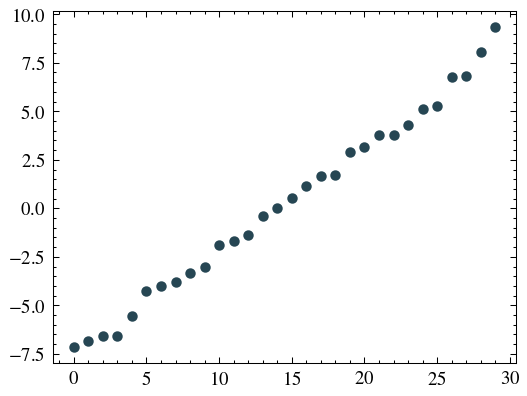

In [26]:
if model_sym.eig_val is None: 
    model_sym.diagonalize(build=True)

plt.scatter(np.arange(len(model_sym.eig_val)), model_sym.eig_val)
model_sym.eig_val[:10], len(model_sym.eig_val)

#### i) Check matrix-vector product for operators that commute with the Hamiltionian $[H, O] = 0$

In [27]:
s_new   = model_sym.matvec(model_sym.eig_vec[:, :10], hilbert_in=hilbert_sym)
s_ovr0  = np.dot(model_sym.eig_vec[:, 0], s_new)
s_ovr1  = np.dot(model_sym.eig_vec[:, 1], s_new)
s_ovr0, s_ovr1

(array([-7.15595497e+00+0.j,  2.06609690e-16+0.j, -9.99200722e-16+0.j,
        -4.22565866e-17+0.j, -1.01587514e-17+0.j,  1.10062116e-16+0.j,
        -6.25776566e-16+0.j, -1.85729227e-16+0.j,  5.07942463e-17+0.j,
        -6.10622664e-16+0.j]),
 array([-8.66519672e-17+0.j, -6.83620973e+00+0.j, -5.13394614e-16+0.j,
        -2.35209247e-15+0.j,  1.79426506e-17+0.j,  4.36597777e-16+0.j,
         1.44687058e-15+0.j,  3.88578059e-16+0.j, -1.53885906e-16+0.j,
         1.71373899e-16+0.j]))

#### ii) Check matrix-vector product for operators that do not commute with the Hamiltionian $[H, O] \neq 0$

##### a) Apply using the generated matrix

In [28]:
sigma_z_mat_sym = sigma_z_0.matrix(hilbert_1=hilbert_sym)
sigma_x_mat_sym = sigma_x_0.matrix(hilbert_1=hilbert_sym)

###### 1. Sigma-Z operator - easy case (commutes with H)

In [29]:
step1_vec_mat_sym       = sigma_z_mat_sym @ model_sym.eig_vec[:, 0]
step2_vec_mat_sym       = sigma_z_mat_sym @ step1_vec_mat_sym
s_ovr_sym_mat_sym       = np.dot(model_sym.eig_vec[:, 0], step2_vec_mat_sym)
s_ovr_sym_mat_sym

np.complex128(0.25+0j)

###### 2. Sigma-X operator - hard case (does not commute with H)

In [30]:
step1_vec_mat_sym       = sigma_x_mat_sym @ model_sym.eig_vec[:, 0]
step2_vec_mat_sym       = sigma_x_mat_sym @ step1_vec_mat_sym
s_ovr_sym_mat_sym       = np.dot(model_sym.eig_vec[:, 0], step2_vec_mat_sym)
s_ovr_sym_mat_sym
#! FIXME: The result is not correct here!

np.complex128(0j)

##### b) Matrix-vector using the `matvec` method

In [ ]:
sig_x_0_2                   = sigma_x_0 @ sigma_x_0
s_new3                      = sig_x_0_2.matvec(model_sym.eig_vec[:, 0], hilbert_in=hilbert_sym, symmetry_mode='project')
s_ovr_sym_mat_sym_matvec_2  = np.dot(model_sym.eig_vec[:, 0], s_new3)
s_ovr_sym_mat_sym_matvec_2

np.complex128(0.24999999999999997+0j)

In [34]:
sig_x_0_2                   = sigma_x_0 @ sigma_x_0
s_new3                      = sig_x_0_2.matvec(model_sym.eig_vec[:, 0], hilbert_in=hilbert_sym, symmetry_mode='project')


In [33]:
%timeit sig_x_0_2.matvec(model_sym.eig_vec[:, 0], hilbert_in=hilbert_sym, symmetry_mode='project')

2.03 ms ± 133 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
sig_zz_0_1                  = sigma_z_0 @ sigma_z_1
s_new4                      = sig_zz_0_1.matvec(model_sym.eig_vec[:, 0], hilbert_in=hilbert_sym, symmetry_mode='project')
s_ovr_sym_mat_sym_matvec_3  = np.dot(model_sym.eig_vec[:, 0], s_new4)
s_ovr_sym_mat_sym_matvec_3

np.complex128(0.09279094870178561+0j)

#### Plaquette operator $W_p$ matrix-vector product check

In [39]:
step1_plaq_sym_0  = plaquette1_op.matvec(model_sym.eig_vec[:, :3], hilbert_in=hilbert_sym)
plaq_sym_ovr0     = np.dot(model_sym.eig_vec[:, 0], step1_plaq_sym_0[:, 0])
plaq_sym_ovr1     = np.dot(model_sym.eig_vec[:, 1], step1_plaq_sym_0[:, 1])
plaq_sym_norm     = 2**len(plaquettes[1])
plaq_sym_ovr0 * plaq_sym_norm, plaq_sym_ovr1 * plaq_sym_norm

(np.complex128(-1+0j), np.complex128(0.9999999999999999+0j))

### c) MULTIPLE SYMMETRY SECTORS

In [15]:
all_energies = []
sum_energies = 0

for i in range(lat.lx):
    for j in range(lat.ly):
        for inv in [-1, 1]:
            sym_gen         =   {
                            'translation'   : {
                                                'kx'    :   i,
                                                'ky'    :   j
                                            },
                            'inversion'     : inv
                            }
            hilbert_sym     =   HilbertSpace(
                                    verbose         =   True,
                                    lattice         =   lat, 
                                    sym_gen         =   sym_gen)
            model_sym       =   HeisenbergKitaev(
                                    lattice         =   lat, 
                                    hilbert_space   =   hilbert_sym, 
                                    dtype           =   complex,
                                    K               =   (1.0, 1.0, 1.0))
            if model_sym.eig_val is None: 
                model_sym.diagonalize(build=True)

            # add info
            nh              = model_sym.nh
            sum_energies   += nh
            print(f'kx={i},ky={j},inv={inv} -> nh={nh}/{sum_energies}')
                
            if model_sym.eig_val is not None and nh > 0:
                all_energies.extend(list(model_sym.eig_val))
                
            
all_energies = np.sort(np.array(all_energies).flatten())

15_12_2025_03-20_31 [INFO] 	->[HilbertSpace] Building representatives.
15_12_2025_03-20_31 [INFO] 			->[HilbertSpace] Explicitly requested immediate mapping generation.
15_12_2025_03-20_31 [INFO] 			->Added symmetry generator: Translation_x = 0
15_12_2025_03-20_31 [INFO] 			->Added symmetry generator: Translation_y = 0
15_12_2025_03-20_31 [INFO] 			->Added symmetry generator: Inversion = -1
15_12_2025_03-20_31 [INFO] 		->Built symmetry group with 8 elements (4 translation x 2 base)
15_12_2025_03-20_31 [INFO] 		->[HilbertSpace] SymmetryContainer initialized: 3 generators -> 8 group elements
15_12_2025_03-20_31 [INFO] 		->Generating symmetric basis for 256 states...
15_12_2025_03-20_31 [INFO] 			->Generated phases map. Took: 2.55e-04s
15_12_2025_03-20_31 [INFO] 			->Allocated compact mapping arrays. Took: 4.28e-03s
15_12_2025_03-20_31 [INFO] 			->Identifying unique representatives...
15_12_2025_03-20_31 [INFO] 				->Completed scanning all states. Took: 7.97e-03s
15_12_2025_03-20_31 [INFO

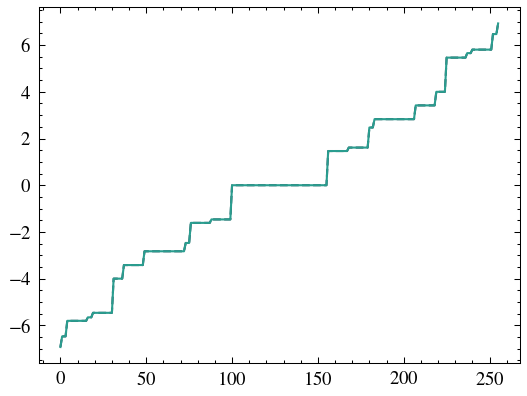

In [17]:
plt.plot(np.sort(all_energies), label = 'sym', ls = '--')
plt.plot(model_no_sym.eig_val, label = 'sym', ls = '-')